211
defaultdict(<class 'int'>, {0: 819377, 2: 897, 1: 13560, 3: 37, 4: 1})
282
Height: 4, Aspect: 2


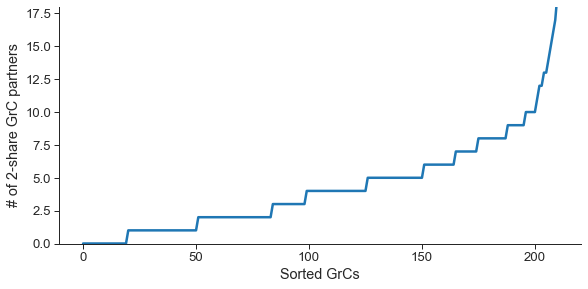

In [3]:

import os
import sys
import importlib
import copy
from collections import defaultdict
sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')

from tools_pattern import get_eucledean_dist

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'distribution_123share_bouton_210519'

import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData, my_box_plot

def to_ng_coord(coord):
    return (
        int(coord[0]/4),
        int(coord[1]/4),
        int(coord[2]/40),
        )

import compress_pickle

# fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/'\
#                                    'mf_grc_model/input_graph_210407_all.gz')
fname = ('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/' \
#          'gen_db/mf_grc/input_graph_210519_all.gz')
         'gen_db/mf_grc/input_graph_210520_all_100_2.gz')
input_graph = compress_pickle.load(fname)

# z_min = 19800
# z_max = 29800
z_min = 19800
z_max = 29800
# GrCs are fully reconstructed and proofread from 90k to 150k
x_min = 105*1000*4
x_max = 135*1000*4
# radius = 200

n_randoms = 5
replication_hist2 = defaultdict(int)
grc_ids = set()
mf_ids = set()
replicated_2shares = defaultdict(int)

def get_prob(in_graph, unique_count=False, count_within_box=True, return_counted=False):
    n_common_pairs = 0
    processed = set()
    total_n_pairs = 0
    hist = defaultdict(int)
    n = 0
    counted_grcs = 0
    for grc_i_id in in_graph.grcs:
        n += 1
        grc_i = in_graph.grcs[grc_i_id]
        x, y, z = grc_i.soma_loc
        if count_within_box:
            if x < x_min or x > x_max:
                continue
            if z < z_min or z > z_max:
                continue
        counted_grcs += 1
        grc_ids.add(grc_i_id)
        rosettes_i = set([mf[1] for mf in grc_i.edges])
        for r in rosettes_i:
            mf_ids.add(r)
        for grc_j_id in in_graph.grcs:
            if grc_i_id == grc_j_id:
                continue
            if unique_count and (grc_i_id, grc_j_id) in processed:
                continue
            processed.add((grc_i_id, grc_j_id))
            processed.add((grc_j_id, grc_i_id))
            grc_j = in_graph.grcs[grc_j_id]
            x, y, z = grc_j.soma_loc
#             if count_within_box:
#                 if x < x_min or x > x_max:
#                     continue
#                 if z < z_min or z > z_max:
#                     continue
            common_rosettes = set([mf[1] for mf in grc_j.edges])
            common_rosettes = common_rosettes & rosettes_i
            hist[len(common_rosettes)] += 1
            if len(common_rosettes) == 2:
                replication_hist2[grc_i_id] += 1
                common_rosettes = tuple(sorted(list(common_rosettes)))
                replicated_2shares[common_rosettes] += 1
    for k in hist:
        # fix 0 datapoint plots
        if hist[k] == 0:
            hist[k] = 1
    if return_counted:
        return hist, counted_grcs
    else:
        return hist

input_observed = copy.deepcopy(input_graph)
hist_data, n_grcs = get_prob(input_observed, count_within_box=True, return_counted=True)

print(n_grcs)
print(hist_data)
print(len(mf_ids))
# n_grcs = len(input_graph.grcs)

replication_hist2_list = []
for grc in grc_ids:
    if grc in replication_hist2:
        replication_hist2_list.append((grc, replication_hist2[grc]))
    else:
        replication_hist2_list.append((grc, 0))
replication_hist2_list_sorted = sorted(replication_hist2_list, key=lambda x: x[1])

mpd = MyPlotData()
mpd_count = MyPlotData()
i = 0
for grc_id, count in replication_hist2_list_sorted:
    mpd_count.add_data_point(
        count=count,
        grc_id=grc_id,
        i=i,
        model='Observed',
    )
    i += 1

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_count,
    x='i',
    y='count',
#     kind='hist',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    ylim=[0, 18],
    height=4,
    aspect=2,
    y_axis_label='# of 2-share GrC partners',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_line.svg',
    show=True,
    )

Height: 3, Aspect: 1.3333333333333333


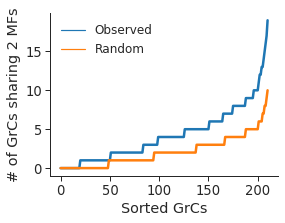

In [9]:

mpd_all = MyPlotData()
mpd_all.append(mpd_count)
mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_dist_X_420000_540000_Z_19800_29800.gz').add_key_value(
    'model', 'Random')
mpd_all.append(mpd_random)

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='top left', frameon=False, fontsize=12)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_all,
    x='i',
    y='count',
    hue='model',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=3,
    width=4,
    y_axis_label='# of GrCs sharing 2 MFs',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_observed_vs_random.svg',
    show=True,
    custom_legend_fn=custom_legend_fn,
    )


Height: 4, Aspect: 1.5


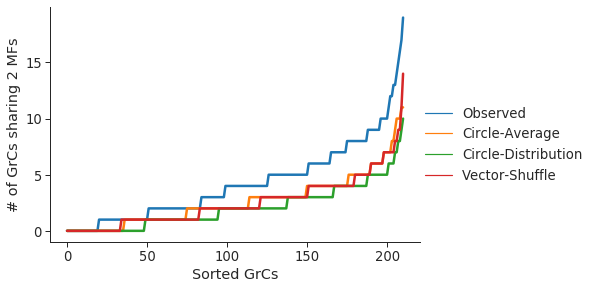

In [20]:

mpd_all = MyPlotData()
mpd_all.append(mpd_count)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_X_420000_540000_Z_19800_29800.gz').add_key_value(
    'model', 'Circle-Average')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_dist_X_420000_540000_Z_19800_29800.gz').add_key_value(
    'model', 'Circle-Distribution')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
#     'distribution_123share_bouton_210519_random_edge_global_15000_X_420000_540000_Z_19800_29800.gz'
    'distribution_123share_bouton_210519_random_edge_global_10000_X_420000_540000_Z_19800_29800.gz'
        ).add_key_value('model', 'Vector-Shuffle')
mpd_all.append(mpd_random)

# def custom_legend_fn(plt):
# #     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
#     plt.legend(loc='top left', frameon=False, fontsize=12)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_all,
    x='i',
    y='count',
    hue='model',
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    width=6,
    y_axis_label='# of GrCs sharing 2 MFs',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_observed_vs_random_supp.svg',
    show=True,
#     custom_legend_fn=custom_legend_fn,
    )


Height: 4, Aspect: 1.5


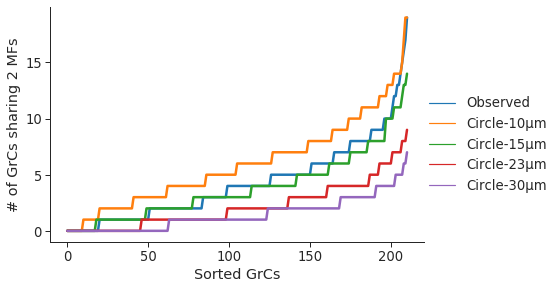

In [22]:

mpd_all = MyPlotData()
mpd_all.append(mpd_count)

# mpd_random = compress_pickle.load(
#     'distribution_123share_bouton_210519_random_circle_const_15000_X_420000_540000_Z_19800_29800.gz'
# #     'distribution_123share_bouton_210519_random_circle_const_15000_margin_10000_X_420000_540000_Z_19800_29800.gz'
# #     'distribution_123share_bouton_210519_random_edge_global_15000_X_420000_540000_Z_19800_29800.gz'
# #     'distribution_123share_bouton_210519_random_edge_global_15000_X_420000_540000_Z_19800_29800.gz'
# #     'distribution_123share_bouton_210519_random_edge_global_15000_X_420000_540000_Z_19800_29800.gz'
# #     'distribution_123share_bouton_210519_random_edge_global_15000_X_420000_540000_Z_19800_29800.gz'
#         ).add_key_value('model', 'Circle-15k')
# mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_15000_margin_10000_X_420000_540000_Z_19800_29800.gz'
        ).add_key_value('model', 'Circle-15µm')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_10000_margin_10000_X_420000_540000_Z_19800_29800.gz'
        ).add_key_value('model', 'Circle-10µm')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_23000_margin_10000_X_420000_540000_Z_19800_29800.gz'
        ).add_key_value('model', 'Circle-23µm')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_30000_margin_10000_X_420000_540000_Z_19800_29800.gz'
        ).add_key_value('model', 'Circle-30µm')
mpd_all.append(mpd_random)

# def custom_legend_fn(plt):
# #     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
#     plt.legend(loc='top left', frameon=False, fontsize=12)

importlib.reload(my_plot); my_plot.my_relplot(
    mpd_all,
    x='i',
    y='count',
    hue='model',
    hue_order=['Observed', 'Circle-10µm', 'Circle-15µm', 'Circle-23µm', 'Circle-30µm', ],
    context='paper',
    linewidth=2.5,
#     kde=True,
#     stat='density',
    height=4,
    width=6,
    y_axis_label='# of GrCs sharing 2 MFs',
    x_axis_label='Sorted GrCs',
    save_filename=f'{script_n}_observed_vs_random_supp_circle.svg',
    show=True,
#     custom_legend_fn=custom_legend_fn,
    )


Height: 3, Aspect: 1.5


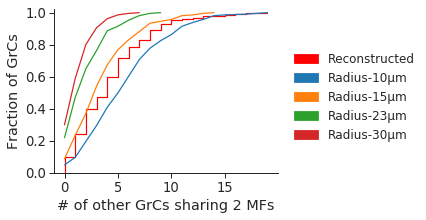

In [28]:

mpd_all = MyPlotData()
mpd_all.append(mpd_count)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_15000_margin_10000_X_420000_540000_Z_19800_29800.gz')
mpd_random = mpd_random.to_histogram('count', hist_key='2shares', hist_val='count')
mpd_random.add_key_value('model', 'Radius-15µm')
mpd_random.add_cdf('count')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_10000_margin_10000_X_420000_540000_Z_19800_29800.gz')
mpd_random = mpd_random.to_histogram('count', hist_key='2shares', hist_val='count')
mpd_random.add_key_value('model', 'Radius-10µm')
mpd_random.add_cdf('count')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_23000_margin_10000_X_420000_540000_Z_19800_29800.gz')
mpd_random = mpd_random.to_histogram('count', hist_key='2shares', hist_val='count')
mpd_random.add_key_value('model', 'Radius-23µm')
mpd_random.add_cdf('count')
mpd_all.append(mpd_random)

mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_const_30000_margin_10000_X_420000_540000_Z_19800_29800.gz')
mpd_random = mpd_random.to_histogram('count', hist_key='2shares', hist_val='count')
mpd_random.add_key_value('model', 'Radius-30µm')
mpd_random.add_cdf('count')
mpd_all.append(mpd_random)

mpd_count_observed = copy.copy(mpd_count)
mpd_count_observed.add_key_value('model', 'Reconstructed')
import matplotlib.pyplot as plt
plt.subplots(figsize=(4, 3))
import seaborn as sns
ax = sns.ecdfplot(data=mpd_count_observed.to_dataframe(), x="count", palette=palette, hue='model')

importlib.reload(my_plot); my_plot.my_lineplot(
    mpd_all,
    x='2shares',
    y='count_cdf',
    hue='model',
    hue_order=['Radius-10µm', 'Radius-15µm', 'Radius-23µm', 'Radius-30µm', ],
    context='paper',
#     palette=palette,
    linewidth=1.25,
    ylim=[0, 1.02],
    height=3,
    width=4.5,
#     aspect=2,
    y_axis_label='Fraction of GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_supp_circle_cdf.svg',
    no_show=True,
    )

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Reconstructed')
patch0 = mpatches.Patch(color=sns.color_palette()[0], label='Radius-10µm')
patch1 = mpatches.Patch(color=sns.color_palette()[1], label='Radius-15µm')
patch2 = mpatches.Patch(color=sns.color_palette()[2], label='Radius-23µm')
patch3 = mpatches.Patch(color=sns.color_palette()[3], label='Radius-30µm')
# plt.legend(handles=[red_patch, black_patch])
plt.legend(frameon=False, fontsize=12, handles=[red_patch, patch0, patch1, patch2, patch3],
          bbox_to_anchor=(1.025, .8),)
# plt.legend(labels=['legendEntry1', 'legendEntry2'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{script_n}_supp_circle_cdf.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()


Height: 4, Aspect: 1.0


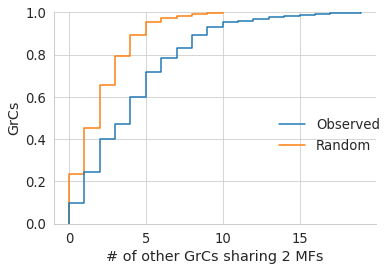

In [31]:

mpd_all = MyPlotData()
mpd_all.append(mpd_count)
mpd_random = compress_pickle.load(
    'distribution_123share_bouton_210519_random_circle_dist_X_420000_540000_Z_19800_29800.gz').add_key_value(
    'model', 'Random')
mpd_all.append(mpd_random)

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='top left', frameon=False, fontsize=12)

importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    x='count',
    hue='model',
#     kind='kde',
    kind='ecdf',
    context='paper',
#     linewidth=2.5,
#     ylim=[0, 50],
    height=4,
    width=4,
#     aspect=2,
    y_axis_label='GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_observed_vs_random_cdf.svg',
    show=True,
#     custom_legend_fn=custom_legend_fn,
    )


Height: 3, Aspect: 1.5


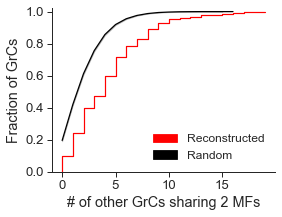

In [12]:
mpd_all = MyPlotData()
# mpd_random = compress_pickle.load(
#     'distribution_123share_bouton_210519_random_circle_dist_X_420000_540000_Z_19800_29800.gz')
# mpd_random = mpd_random.to_histogram('count', hist_key='2shares', hist_val='count')
# mpd_random.add_key_value('model', 'Random')
# mpd_random.add_cdf('count')
# mpd_all.append(mpd_random)
db = compress_pickle.load('distribution_123share_bouton_210519_random_gen_circle_dist_100.gz')
for trial in db:
    hist = defaultdict(int)
    for v in trial:
        hist[v] += 1
    mpd_random = MyPlotData()
    for k, v in sorted(hist.items()):
        mpd_random.add(
            two_shares=k,
            count=v,
            model='Random'
        )
    mpd_random.add_cdf('count')
    mpd_all.append(mpd_random)

mpd_count_observed = copy.copy(mpd_count)
mpd_count_observed.add_key_value('model', 'Reconstructed')
import matplotlib.pyplot as plt
plt.subplots(figsize=(4, 3))
import seaborn as sns
palette = {
    'Reconstructed': 'red',
    'Random': 'black',
}
ax = sns.ecdfplot(data=mpd_count_observed.to_dataframe(), x="count", palette=palette, hue='model')

def custom_legend_fn(plt):
#     plt.legend(bbox_to_anchor=(1.025, .8), loc='upper left', borderaxespad=0.)
    plt.legend(loc='top left', frameon=False, fontsize=12)


importlib.reload(my_plot); my_plot.my_lineplot(
    mpd_all,
    x='two_shares',
    y='count_cdf',
    hue='model',
    context='paper',
    palette=palette,
    linewidth=1.25,
    ylim=[0, 1.02],
    height=3,
    width=4.5,
#     aspect=2,
    y_axis_label='Fraction of GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_observed_vs_random_cdf.svg',
    no_show=True,
    )

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Reconstructed')
black_patch = mpatches.Patch(color='black', label='Random')
# plt.legend(handles=[red_patch, black_patch])
plt.legend(loc='top right', frameon=False, fontsize=12, handles=[red_patch, black_patch])
# plt.legend(labels=['legendEntry1', 'legendEntry2'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{script_n}_observed_vs_random_cdf.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()



Height: 3, Aspect: 1.5


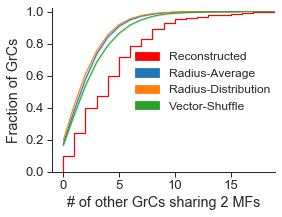

In [51]:
mpd_all = MyPlotData()
# mpd_all.append(mpd_count)

def add_simulations(fin, model_name):
    db = compress_pickle.load(fin)
    for trial in db:
        hist = defaultdict(int)
        for v in trial:
            hist[v] += 1
        mpd_random = MyPlotData()
        for k, v in sorted(hist.items()):
            mpd_random.add(
                two_shares=k,
                count=v,
                model=model_name
            )
        mpd_random.add_cdf('count')
        mpd_all.append(mpd_random)


add_simulations('distribution_123share_bouton_210519_random_gen_circle_constant_100.gz',
               'Radius-Average')
add_simulations('distribution_123share_bouton_210519_random_gen_circle_dist_100.gz',
               'Radius-Distribution')
add_simulations('distribution_123share_bouton_210519_random_gen_vector_100.gz',
               'Vector-Shuffle')

mpd_count_observed = copy.copy(mpd_count)
mpd_count_observed.add_key_value('model', 'Reconstructed')
import matplotlib.pyplot as plt
plt.subplots(figsize=(4, 3))
import seaborn as sns
palette = {
    'Reconstructed': 'red',
    'Random': 'black',
}
ax = sns.ecdfplot(data=mpd_count_observed.to_dataframe(), x="count", palette=palette, hue='model')

importlib.reload(my_plot); my_plot.my_lineplot(
    mpd_all,
    x='two_shares',
    y='count_cdf',
    hue='model',
    hue_order=['Radius-Average', 'Radius-Distribution', 'Vector-Shuffle'],
    context='paper',
#     palette=palette,
    linewidth=1,
    ylim=[0, 1.02],
    xlim=[-1, 19],
    height=3,
    width=4.5,
#     aspect=2,
    y_axis_label='Fraction of GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_supp_circle_cdf.svg',
    no_show=True,
    )

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Reconstructed')
patch0 = mpatches.Patch(color=sns.color_palette()[0], label='Radius-Average')
patch1 = mpatches.Patch(color=sns.color_palette()[1], label='Radius-Distribution')
patch2 = mpatches.Patch(color=sns.color_palette()[2], label='Vector-Shuffle')
# plt.legend(handles=[red_patch, black_patch])
plt.legend(frameon=False, fontsize=12, handles=[red_patch, patch0, patch1, patch2],
          bbox_to_anchor=(1.025, .8),)
# plt.legend(labels=['legendEntry1', 'legendEntry2'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{script_n}_supp_cdf.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()


Height: 3, Aspect: 1.5


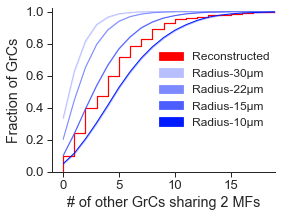

In [55]:
mpd_all = MyPlotData()

def add_simulations(fin, model_name):
    db = compress_pickle.load(fin)
    for trial in db:
        hist = defaultdict(int)
        for v in trial:
            hist[v] += 1
        mpd_random = MyPlotData()
        for k, v in sorted(hist.items()):
            mpd_random.add(
                two_shares=k,
                count=v,
                model=model_name
            )
        mpd_random.add_cdf('count')
        mpd_all.append(mpd_random)

add_simulations('distribution_123share_bouton_210519_random_gen_circle_constant10_2_100.gz',
               'Radius-10µm')
add_simulations('distribution_123share_bouton_210519_random_gen_circle_constant15_2_100.gz',
               'Radius-15µm')
add_simulations('distribution_123share_bouton_210519_random_gen_circle_constant22_2_100.gz',
               'Radius-22µm')
add_simulations('distribution_123share_bouton_210519_random_gen_circle_constant30_2_100.gz',
               'Radius-30µm')

mpd_count_observed = copy.copy(mpd_count)
mpd_count_observed.add_key_value('model', 'Reconstructed')
import matplotlib.pyplot as plt
plt.subplots(figsize=(4, 3))
import seaborn as sns
palette = {
    'Reconstructed': 'red',
    'Random': 'black',
}
ax = sns.ecdfplot(data=mpd_count_observed.to_dataframe(), x="count", palette=palette, hue='model')

# palette = ['#001aff', '#4d5eff', '#7d8aff', '#b8bfff']
palette = {
    'Radius-10µm': '#001aff',
    'Radius-15µm': '#4d5eff',
    'Radius-22µm': '#7d8aff',
    'Radius-30µm': '#b8bfff',
}

importlib.reload(my_plot); my_plot.my_lineplot(
    mpd_all,
    x='two_shares',
    y='count_cdf',
    hue='model',
    hue_order=['Radius-30µm', 'Radius-22µm', 'Radius-15µm', 'Radius-10µm'],
    context='paper',
#     palette=palette,
    linewidth=1,
    ylim=[0, 1.02],
    xlim=[-1, 19],
    height=3,
    width=4.5,
#     aspect=2,
    palette=palette,
    y_axis_label='Fraction of GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_supp_circle_cdf.svg',
    no_show=True,
    )

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Reconstructed')
patch0 = mpatches.Patch(color='#001aff', label='Radius-10µm')
patch1 = mpatches.Patch(color='#4d5eff', label='Radius-15µm')
patch2 = mpatches.Patch(color='#7d8aff', label='Radius-22µm')
patch3 = mpatches.Patch(color='#b8bfff', label='Radius-30µm')
# plt.legend(handles=[red_patch, black_patch])
plt.legend(frameon=False, fontsize=12, handles=[red_patch, patch3, patch2, patch1, patch0],
          bbox_to_anchor=(1.025, .8),)
# plt.legend(labels=['legendEntry1', 'legendEntry2'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f'{script_n}_supp_circle_cdf.svg', bbox_inches='tight', transparent=True)
plt.show()
plt.close()


Height: 4, Aspect: 1.0


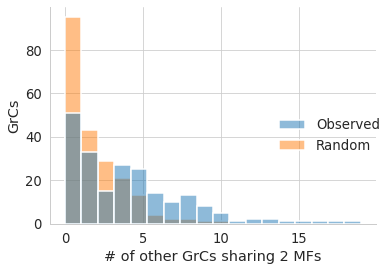

In [32]:

importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    x='count',
    hue='model',
#     kind='kde',
#     kde=True,
#     kind='ecdf',
    context='paper',
#     linewidth=2.5,
#     ylim=[0, 50],
    height=4,
    width=4,
#     aspect=2,
    y_axis_label='GrCs',
    x_axis_label='# of other GrCs sharing 2 MFs',
    save_filename=f'{script_n}_observed_vs_random_pdf.svg',
    show=True,
#     custom_legend_fn=custom_legend_fn,
    )


In [37]:
from scipy.stats import kurtosis
observed = []
for i in mpd_count.data:
    observed.append(i['count'])
print(f'Observed: {kurtosis(observed)}')
random_vals = []
for i in mpd_random.data:
    random_vals.append(i['count'])
print(f'Random: {kurtosis(random_vals)}')

Observed: 2.0295161541755258
Random: 1.6217850856396945


In [39]:
import scipy.stats
scipy.stats.ranksums(observed, random_vals)

RanksumsResult(statistic=6.939172179934833, pvalue=3.944042007706307e-12)

In [40]:
len(observed)

211